# Exercice de crunching de data - Base de donnée TicTacTrip

Les buts de l'exercice sont les suivants :
   - Extraire des infos intéressantes type prix min, moyen et max, durée min/max/moyenne par trajet sur la base de donnée
   - Quantifier des différences de prix moyen et de durée selon le train, le bus et le covoit, et selon la distance du trajet (0-200km, 201-800km, 800-2000km, 2000+km) 

**Plan du Notebook :**
1. Import des données et manipulation des DataFrames  
    1.1 Helper fonctions  
    1.2 Import des données  
    1.3 Calculs et jointures pour l'extraction d'informations intéressantes  
2. Extraction d'informations générale intéressantes  
    2.1 Géographie des trajets requêtés  
    2.2 Statistiques sur les prix par trajet  
    2.3 Statistiques sur les durées par trajet  
3. Extraction d'informations selon les distances de trajet  
    3.1 Calcul des statistiques  
    3.2 Visualisation sur les différences de prix  
    3.3 Visualisation sur les différences de durée  
4. Bonus : algorithme de prédiction des prix  
    4.1 Feature engineering  
    4.2 Entrainement de l'algorithme  
    4.3 Qualité des prédictions

**Imports Python**

In [1]:
import pandas as pd
import numpy as np
from geopy.distance import distance
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection
import seaborn as sns
sns.set()

## 1. Import des données et manipulation des DataFrames
Cette partie expose l'import des fichiers de données en format DataFrame, puis la manipulation de ces DataFrame afin d'effectuer les jointures et calculs nécessaires pour la suite de l'exercice.

### 1.1 Helper fonctions
Je définis ici les fonctions qui me seront utiles par la suite : 
- la fonction distancer permet de calculer une distance géodésique entre 2 points
- la fonction deltatime_to_hour permet de convertir une durée de type timedelta64 en heure décimale.

In [2]:
def distancer(row):
    """Fonction de calcul de distance en km entre les points d'origine et de destination"""
    coords_1 = (row['o_latitude'], row['o_longitude'])
    coords_2 = (row['d_latitude'], row['d_longitude'])
    return distance(coords_1, coords_2).km

In [3]:
def timedelta_to_hours(row, col):
    """Fonction de conversion de durée de type timedelta64 en heure décimale
    row : ligne du DataFrame
    col : colonne du DataFrame à convertir"""
    days = row[col].days
    seconds = row[col].seconds
    hours = days * 24 + seconds / 3600
    return hours

### 1.2 Import des données

J'importe les données, certaines colonnes du fichier ticket_data contiennent des dates à importer au bon format:

In [4]:
# cities
cities = pd.read_csv('data/cities.csv', index_col='id')
# providers
providers = pd.read_csv('data/providers.csv', index_col='id')
# stations
stations = pd.read_csv('data/stations.csv', index_col='id')
# ticket_data
parse_dates = ['departure_ts', 'arrival_ts', 'search_ts'] # colonnes contenant des timestamps
ticket_data = pd.read_csv('data/ticket_data.csv', index_col='id', parse_dates=parse_dates)

In [5]:
ticket_data.head()

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
id,,,,,,,,,,,
6795025,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,542
6795026,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,542
6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542
6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,542
6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,542


In [6]:
cities.head()

,local_name,unique_name,latitude,longitude,population
id,,,,,
5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


In [7]:
stations.head()

,unique_name,latitude,longitude
id,,,
1,Aalen (Stuttgarter Straße),48.835296,10.092956
2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
3,Aéroport CDG,49.009900,2.559310
4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
5,Aéroport de Dresden,51.123604,13.764737


In [8]:
providers.head()

,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
id,,,,,,,,,
9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
11,3,NaN,infobus,Infobus,False,False,False,False,bus
12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
13,5,NaN,flixbus,Flixbus,True,False,False,False,bus


### 1.3 Calculs et jointures pour l'extraction d'informations intéressantes

Cette partie consistera à effectuer les calculs et jointures sur les données afin d'en extraire des informations intéressantes ou nécessaire par la suite.

In [9]:
# Conversion des prix en euros
ticket_data['price'] = ticket_data['price_in_cents'] / 100

In [10]:
# Calcul des durées de trajet et conversion en heure
ticket_data['travel_time'] = ticket_data.arrival_ts - ticket_data.departure_ts
ticket_data['travel_time_hours'] = ticket_data.apply(timedelta_to_hours, args=['travel_time'], axis=1)

In [11]:
# Merge des informations sur les coordonnées dans le DataFrame ticket_data
ticket_data = pd.merge(ticket_data, cities[['latitude', 'longitude']], how='left', left_on=['o_city'], right_on=['id'])
ticket_data.rename(columns={'latitude': 'o_latitude', 'longitude': 'o_longitude'}, inplace=True)
ticket_data = pd.merge(ticket_data, cities[['latitude', 'longitude']], how='left', left_on=['d_city'], right_on=['id'])
ticket_data.rename(columns={'latitude': 'd_latitude', 'longitude': 'd_longitude'}, inplace=True)

In [12]:
# Calcul des distance de trajet
ticket_data['distance'] = ticket_data.apply(distancer, axis=1)

In [13]:
# Merge des providers dans le DataFrame ticket_data
ticket_data = pd.merge(ticket_data, providers[['fullname', 'transport_type']], how='left', left_on=['company'], right_on=['id'])

Le DataFrame ticket_data est maintenant enrichi des informations nécessaires pour la suite, ce sera notre DataFrame principal de travail : 

In [14]:
ticket_data.head()

,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,...,price,travel_time,travel_time_hours,o_latitude,o_longitude,d_latitude,d_longitude,distance,fullname,transport_type
0,8385,NaN,NaN,2017-10-13 14:00:00+00:00,2017-10-13 20:10:00+00:00,4550,2017-10-01 00:13:31.327000+00:00,NaN,NaN,611,...,45.5,0 days 06:10:00,6.166667,47.907018,1.90627,43.604452,3.918318,503.136831,Blablacar,carpooling
1,9,63.0,1044.0,2017-10-13 13:05:00+00:00,2017-10-14 06:55:00+00:00,1450,2017-10-01 00:13:35.773000+00:00,"{149,418}",{13},611,...,14.5,0 days 17:50:00,17.833333,47.907018,1.90627,43.604452,3.918318,503.136831,Ouibus,bus
2,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 21:24:00+00:00,7400,2017-10-01 00:13:40.212000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,74.0,1 days 07:57:00,31.950000,47.907018,1.90627,43.604452,3.918318,503.136831,Intercités,train
3,8377,5905.0,6495.0,2017-10-13 13:27:00+00:00,2017-10-14 11:02:00+00:00,13500,2017-10-01 00:13:40.213000+00:00,"{798,798,6794,6246}","{8377,8376}",611,...,135.0,0 days 21:35:00,21.583333,47.907018,1.90627,43.604452,3.918318,503.136831,Intercités,train
4,8381,5905.0,6495.0,2017-10-13 21:46:00+00:00,2017-10-14 19:32:00+00:00,7710,2017-10-01 00:13:40.213000+00:00,"{5983,5983}",{8380},611,...,77.1,0 days 21:46:00,21.766667,47.907018,1.90627,43.604452,3.918318,503.136831,Intercités de Nuit,train


## 2. Extraction d'informations générale intéressantes
On va maintenant étudier plusieurs aspects généraux sur nos données :
- La géographie des voyages requêtés,
- Les statistiques sur les prix et les durées de trajet, comme demandé dans le premier point de l'exercice.

### 2.1 Géographie des trajets requêtés
Je commence par tracer une carte représentant les trajets requêtés. Cela permettra d'avoir une idée plus précise de ce que contient le dataset pour mieux le comprendre :

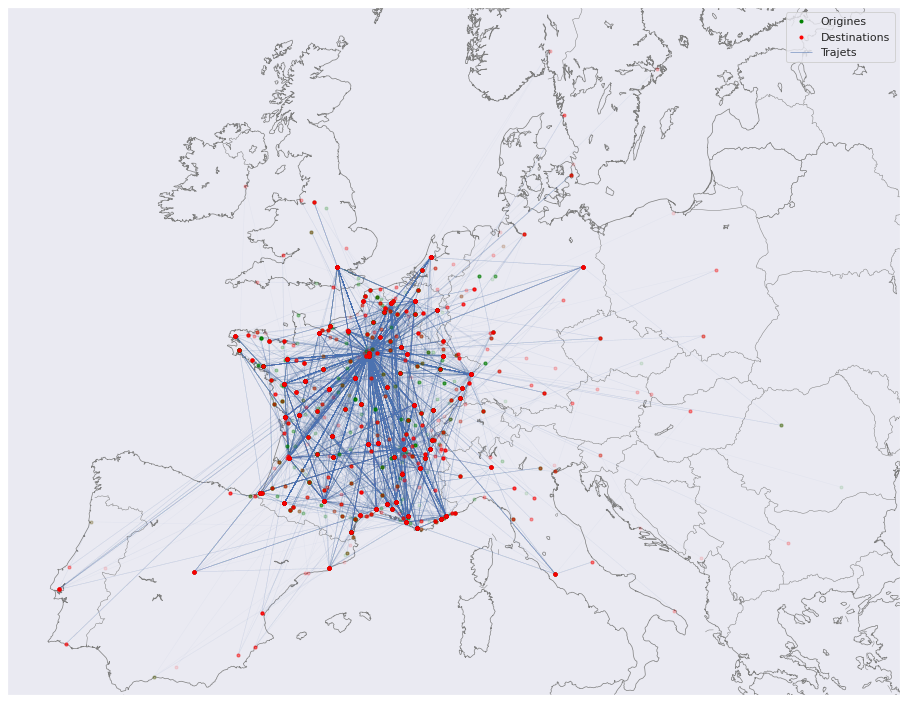

In [15]:
plt.figure(figsize=(16,16))

# Tracé du fond de carte
m = Basemap(llcrnrlon=-10, llcrnrlat=35, urcrnrlon=35, urcrnrlat=60,
             resolution='i', projection='tmerc', lat_0=48.9, lon_0=15.3)

m.drawcoastlines(linewidth=0.72, color='gray')
m.drawcountries(zorder=0, color='gray')

# On regroupe les données par requête utilisateur
df_temp = ticket_data.groupby(['search_ts', 'o_city', 'd_city']).mean()

# Extraction des coordonnées
lon1, lat1 = m(df_temp.o_longitude.values, df_temp.o_latitude.values)
lon2, lat2 = m(df_temp.d_longitude.values, df_temp.d_latitude.values)

# Tracé des points et des lignes de connexion
pts = np.c_[lon1, lat1, lon2, lat2].reshape(len(lon1), 2, 2)
plt.gca().add_collection(LineCollection(pts, label="Trajets", alpha=0.05, linewidth=0.5))

m.plot(lon1, lat1, marker=".", ls="", label="Origines", color="green", alpha=0.1)
m.plot(lon2, lat2, marker=".", ls="", label="Destinations", color="red", alpha=0.1)

# Légende
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    try:
        lh._legmarker.set_alpha(1)
    except:
        pass

plt.show()

Sur cette carte, plus un trajet est opaque, plus il a été requêté de nombreuses fois.  
On peut déduire plusieurs informations de cette carte :
- Les données semblent bien concerner des trajets effectués en Europe,
- Le coeur du réseau est situé en France,
- Les trajets les plus requêtés semblent être ceux effectués entre les grandes villes Françaises et Paris en particulier,
- En dehors de France, on devine quelques destinations populaires (Londres, Madrid, Berlin, Rome, Lisbonne, Amsterdam...).  

Pour effectuer ces trajets, voyons quels sont les types de transports proposés dans la base de données :

In [16]:
print(providers.transport_type.unique())

['bus' 'car' 'train' 'carpooling']


### 2.2 Statistiques sur les prix par trajet

On va maintenant extraire des informations sur les prix par trajet :

In [17]:
# Jointure sur l'id des villes
trip_prices = pd.merge(ticket_data[['o_city', 'd_city', 'price']], cities[['unique_name']], how='left', left_on='o_city', right_on=['id'])
trip_prices.rename(columns={'unique_name': 'o_name'}, inplace=True)
trip_prices = pd.merge(trip_prices, cities[['unique_name']], how='left', left_on='d_city', right_on=['id'])
trip_prices.rename(columns={'unique_name': 'd_name'}, inplace=True)

# Calcul des statistiques de prix par trajet
trip_prices = trip_prices.groupby(['o_name', 'd_name']).agg({'price': ['count', 'min', 'max', 'mean']})

trip_prices

price                          
                                         count    min    max        mean
o_name                d_name                                            
aeroport-paris-vatry- troyes                 1   53.0   53.0   53.000000
agde                  amsterdam              5  186.0  220.0  203.200000
agen                  dijon                  2   98.6  136.5  117.550000
                      marseille             30   20.0   89.2   40.426667
                      marseille-aeroport     6   37.0   40.5   38.333333
...                                        ...    ...    ...         ...
villefranche-sur-cher bordeaux              10   30.6   76.7   58.850000
vitre                 nice                   2  150.7  219.2  184.950000
zurich                dijon                  4   14.0   24.0   18.725000
                      liege                  9   40.5   41.9   40.966667
                      strasbourg             5   14.0   17.8   15.900000

[1437 rows x 4 columns]

On peux maintenant effectuer des requêtes aisément pour obtenir les statistiques de prix entre 2 villes:

In [18]:
# Choix des villes
ville1 = 'paris'
ville2 = 'annecy'

print("statistiques sur les prix du trajet {} - {} :".format(ville1, ville2))
print(trip_prices.loc[ville1, ville2])

statistiques sur les prix du trajet paris - annecy :
price  count    105.000000
       min       21.900000
       max      113.600000
       mean      50.842857
Name: (paris, annecy), dtype: float64


### 2.3 Statistiques sur les durées par trajet

On étudie maintenant les statistiques sur les durées par trajet :

In [19]:
# Jointure sur l'id des villes
trip_durations = pd.merge(ticket_data[['o_city', 'd_city', 'travel_time', 'travel_time_hours']], cities[['unique_name']], how='left', left_on='o_city', right_on=['id'])
trip_durations.rename(columns={'unique_name': 'o_name'}, inplace=True)
trip_durations = pd.merge(trip_durations, cities[['unique_name']], how='left', left_on='d_city', right_on=['id'])
trip_durations.rename(columns={'unique_name': 'd_name'}, inplace=True)

# Calcul des statistiques de prix par trajet
trip_durations = trip_durations.groupby(['o_name', 'd_name']).agg({'travel_time': ['min', 'max', pd.Series.mean]})

trip_durations

travel_time                         
                                                 min             max     mean
o_name                d_name                                                 
aeroport-paris-vatry- troyes                21:55:00 0 days 21:55:00 21:55:00
agde                  amsterdam             08:53:00 0 days 15:54:00 10:18:48
agen                  dijon                 12:24:00 0 days 15:01:00 13:42:30
                      marseille             05:36:00 0 days 12:20:00 08:17:24
                      marseille-aeroport    05:00:00 0 days 08:00:00 05:50:00
...                                              ...             ...      ...
villefranche-sur-cher bordeaux              03:10:00 1 days 13:44:00 11:40:30
vitre                 nice                  09:53:00 0 days 11:05:00 10:29:00
zurich                dijon                 08:10:00 0 days 17:45:00 12:57:30
                      liege                 05:50:00 0 days 11:30:00 07:43:20
                      strasbourg            04:55:00 0 days 10:35:00 07:00:00

[1437 rows x 3 columns]

On peux maintenant effectuer des requêtes aisément pour obtenir les statistiques sur les temps de trajet entre 2 villes:

In [20]:
# Choix des villes
ville1 = 'paris'
ville2 = 'annecy'

print("statistiques sur les temps de trajet {} - {} :".format(ville1, ville2))
print(trip_durations.loc[ville1, ville2])

statistiques sur les temps de trajet paris - annecy :
travel_time  min           0 days 03:40:00
             max           1 days 08:40:00
             mean   0 days 08:13:14.857142
Name: (paris, annecy), dtype: timedelta64[ns]


## 3. Extraction d'informations selon les distances de trajet

Dans cette partie nous allons nous intéresser aux différences de prix et de durées selon les distances de trajet, afin de répondre au deuxième point de l'exercice.  

### 3.1 Calcul des statistiques

In [21]:
# classification 0-200km, 201-800km, 800-2000km, 2000+km
ticket_data.loc[ticket_data.distance <= 200, 'dist_class'] = '[0, 200]'
ticket_data.loc[(ticket_data.distance > 200) & (ticket_data.distance <= 800), 'dist_class'] = '[201, 800]'
ticket_data.loc[(ticket_data.distance > 800) & (ticket_data.distance <= 2000), 'dist_class'] = '[801, 2000]'
ticket_data.loc[ticket_data.distance > 2000, 'dist_class'] = '[2001 +)'

On peux maintenant commencer par afficher les statistiques obtenues selon ces classes de distance, en fonction des moyens de transport :

In [22]:
stat_df = ticket_data.groupby(['dist_class', 'transport_type']).agg({'travel_time': ['min', 'max', pd.Series.mean], 'price' : ['min', 'max', 'mean']})
stat_df

travel_time                   \
                                   min              max   
dist_class  transport_type                                
[0, 200]    bus               01:05:00 13 days 05:45:00   
            carpooling        00:20:00  0 days 17:20:00   
            train             00:39:00  1 days 10:27:00   
[201, 800]  bus               02:29:00 20 days 12:51:00   
            carpooling        01:20:00  0 days 19:50:00   
            train             01:08:00  2 days 00:27:00   
[801, 2000] bus               12:15:00 14 days 17:00:00   
            carpooling        07:50:00  1 days 05:10:00   
            train             03:33:00  1 days 16:37:00   

                                                   price                     
                                             mean    min    max        mean  
dist_class  transport_type                                                   
[0, 200]    bus            0 days 10:13:57.053140   8.50  229.0   21.828309  
            carpooling     0 days 01:57:07.342427   3.00  128.5   11.773524  
            train          0 days 04:25:09.840098   4.90  251.0   34.879008  
[201, 800]  bus            0 days 15:04:29.269314  10.00  224.8   34.948500  
            carpooling     0 days 04:45:47.272436   8.50  138.0   32.180643  
            train          0 days 07:40:39.543514  14.00  385.5   91.247795  
[801, 2000] bus            1 days 03:32:10.027247  22.90  174.0   69.499500  
            carpooling     0 days 13:06:00.839160  44.96  161.5   86.265455  
            train          0 days 12:09:31.021671  19.40  375.5  154.637461

Des visualisations seront utiles pour mieux comprendre ces résultats et les interpréter.

### 3.2 Visualisation sur les différences de prix

On commence par s'intéresser au prix. On peut tracer un histogramme des prix moyens, en fonction de la distance de trajet et du type de transport :

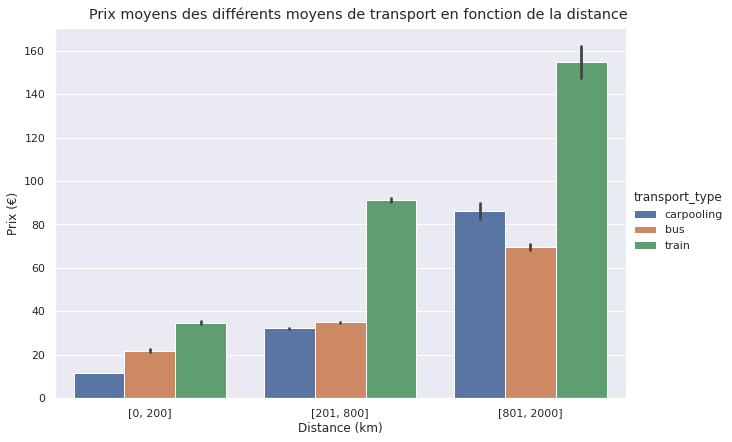

In [23]:
order = ['[0, 200]', '[201, 800]', '[801, 2000]']
g = sns.catplot(x="dist_class", y="price", hue="transport_type", kind="bar", data=ticket_data, height=6, aspect=1.5, order=order)
g.fig.suptitle('Prix moyens des différents moyens de transport en fonction de la distance', x=0.5, y=1.02)
plt.xlabel('Distance (km)')
plt.ylabel('Prix (€)');

On voit que:
- plus la distance est grande, plus les trajets sont chers (ce qui semble bien logique);
- en dessous de 800 km, les trajets en co-voiturage sont les moins chers en moyenne, puis le bus et enfin le train;
- au-delà de 800 jm, les trajets en bus deviennent moins onéreux que les trajets en covoiturage en moyenne.

Pour tirer une idée plus précise de l'évolution des prix par moyens de transport en fonction de la distance, on peux tracer des régression par type de transport :

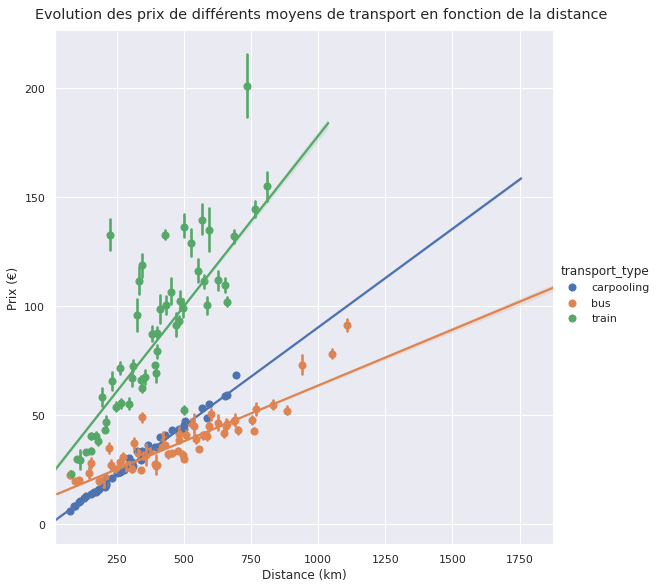

In [24]:
g = sns.lmplot(data=ticket_data, x='distance', y='price', hue='transport_type', markers='o', x_bins=70, height=8) # x_bins = taille des regroupement de données (pour la visu uniquement)
g.fig.suptitle('Evolution des prix de différents moyens de transport en fonction de la distance', x=0.5, y=1.02)
plt.xlabel('Distance (km)')
plt.ylabel('Prix (€)');

Sur cette représentation, on voit que le prix du bus est celui qui augmente le moins vite selon la distance alors que celui du train augmente le plus rapidement.  
Le bus semble devenir plus avantageux par rapport à la voiture à partir d'environ 400 km.  
Attention cependant à l'interprétation de cette figure car si le prix du covoiturage semble suivre une belle relation linéaire en fonction de la distance, la relation semble non-linéaire pour le bus et peut-être également pour le train.

On peut également s'intéresser aux prix proposés par les différents providers sur chacun des types de transports :

In [25]:
# providers sur le co-voiturage
print(ticket_data[ticket_data.transport_type == 'carpooling']['fullname'].unique())

['Blablacar']


Il n'y a pas de concurrence pour BlaBlaCar dans notre jeu de données. On va donc comparer uniquement les providers de bus et de train :

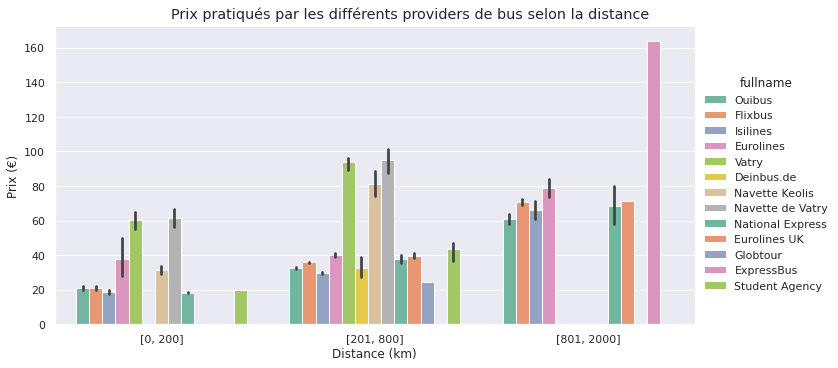

In [26]:
# Bus
g = sns.catplot(x="dist_class", y="price", hue="fullname", kind="bar", data=ticket_data[ticket_data.transport_type == 'bus'], palette="Set2", aspect=2, order=order)
g.fig.suptitle('Prix pratiqués par les différents providers de bus selon la distance', x=0.5, y=1.02)
plt.xlabel('Distance (km)')
plt.ylabel('Prix (€)');

On constate que le provider Vatry pratique des tarifs relativement élevés par rapport aux autres sur les distances sur lesquels il opère, de même que les navette de Keolis à partir de 200 km. Sur les grandes distance, ExpressBus pratique des prix bien plus élevés que la concurrence.

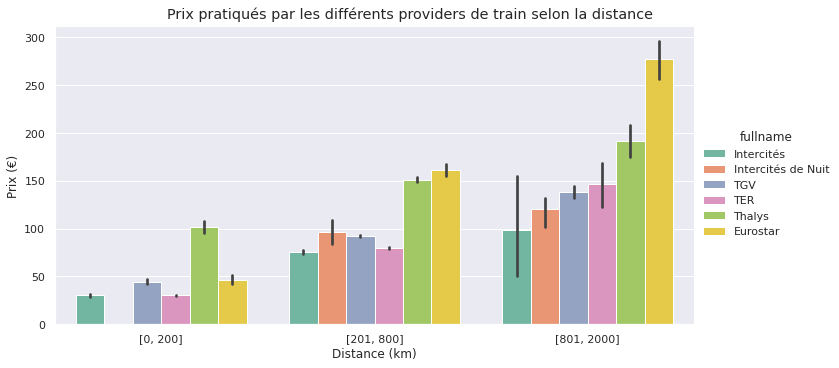

In [27]:
# Train
g = sns.catplot(x="dist_class", y="price", hue="fullname", kind="bar", data=ticket_data[ticket_data.transport_type == 'train'], palette="Set2", aspect=2, order=order)
g.fig.suptitle('Prix pratiqués par les différents providers de train selon la distance', x=0.5, y=1.02)
plt.xlabel('Distance (km)')
plt.ylabel('Prix (€)');

Pour les trains, les providers les plus chers sont le Thalys sur les petites distances, puis Eurostar sur les distance plus importantes. L'intercités propose des prix relativement faible sur chacune des catégories.

### 3.3 Visualisation sur les différences de durée

On s'intéresse maintenant aux durées de trajets par catégories :

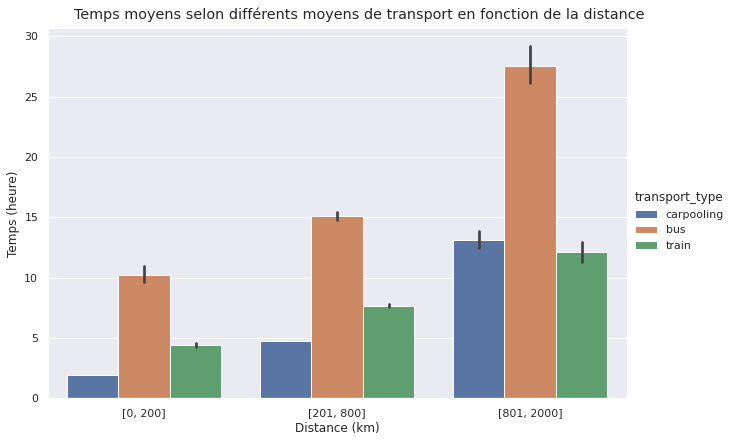

In [28]:
g2 = sns.catplot(x="dist_class", y="travel_time_hours", hue="transport_type", kind="bar", data=ticket_data, height=6, aspect=1.5, order=order);
g2.fig.suptitle('Temps moyens selon différents moyens de transport en fonction de la distance', x=0.5, y=1.02)
plt.xlabel('Distance (km)')
plt.ylabel('Temps (heure)');

Le bus est le plus lent sur chaque catégorie de distance. La voiture est la plus rapide sous 800 km, puis le train est plus rapide sur les grandes distances.

## 4. Bonus : algorithme de prédiction des prix

Arrivé à ce stade il serait dommage de ne pas se faire plaisir en lançant un algorithme de machine learning!  

Je vais essayer d'effectuer une prédiction sur les prix proposés. Cela pourrait par exemple être utile si l'on souhaite déclancher des alertes en cas de prix anormaux (par exemple, un prix anormalement bas pourrait être communiqué à des utilisateurs de l'application effectuant régulièrement le trajet concerné).  
Je vais utiliser l'algorithme Random Forest, un algorithme non linéaire pouvant être appliqué à la régression, qui performe habituellement plutôt bien.

### 4.1 Feature engineering
On va récupérer de nouvelles features sur notre jeu de données en effectuant du feature engineering. Je vais calculer :
- le temps restant entre la recherche du ticket et le départ,
- le nombre de correspondance sur le trajet,
- le mois du départ,
- le nombre de companies proposant un trajet similaire.

In [29]:
# imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [30]:
# Calcul du temps restant entre la recherche et le départ
ticket_data['time_before_departure'] = ticket_data.departure_ts - ticket_data.search_ts
ticket_data['time_before_departure_hours'] = ticket_data.apply(timedelta_to_hours, args=['time_before_departure'], axis=1)

In [31]:
# Calcul du nombre de middle stations
def n_middle_stations(row):
    """Fonction de relevé du nombre de correspondance dans un trajet"""
    m_st = str(row.middle_stations)
    if m_st == 'nan':
        return 0
    else:
        return len(m_st.split(','))
    
ticket_data['n_middle_stations'] = ticket_data.apply(n_middle_stations, axis=1)

In [32]:
# Extraction du mois de départ
def get_month(row):
    """Fonction d'extraction du mois de départ du trajet"""
    month = row.departure_ts.month
    return month
    
ticket_data['month'] = ticket_data.apply(get_month, axis=1)

In [33]:
# Nombre de concurrents proposant un trajet similaire
def n_other_companies(row):
    """Fonction de relevé du nombre de concurrents proposant un trajet identique"""
    other_comp = str(row.other_companies)
    if other_comp == 'nan':
        return 0
    else:
        return len(other_comp.split(','))
    
ticket_data['n_other_companies'] = ticket_data.apply(n_other_companies, axis=1)

In [34]:
ticket_data.columns

Index(['company', 'o_station', 'd_station', 'departure_ts', 'arrival_ts',
       'price_in_cents', 'search_ts', 'middle_stations', 'other_companies',
       'o_city', 'd_city', 'price', 'travel_time', 'travel_time_hours',
       'o_latitude', 'o_longitude', 'd_latitude', 'd_longitude', 'distance',
       'fullname', 'transport_type', 'dist_class', 'time_before_departure',
       'time_before_departure_hours', 'n_middle_stations', 'month',
       'n_other_companies'],
      dtype='object')

In [35]:
features = ['company', 'travel_time_hours', 'distance', 'transport_type', 'time_before_departure_hours', 'n_middle_stations', 'month', 'n_other_companies']
X = ticket_data[features]
y = ticket_data.price.values

In [36]:
X

,company,travel_time_hours,distance,transport_type,time_before_departure_hours,n_middle_stations,month,n_other_companies
0,8385,6.166667,503.136831,carpooling,301.774444,0,10,0
1,9,17.833333,503.136831,bus,300.856667,2,10,1
2,8377,31.950000,503.136831,train,301.221944,4,10,2
3,8377,21.583333,503.136831,train,301.221944,4,10,2
4,8381,21.766667,503.136831,train,309.538611,2,10,1
...,...,...,...,...,...,...,...,...
74163,13,13.500000,339.046766,bus,183.904722,2,10,1
74164,9,6.500000,339.046766,bus,188.404722,2,10,1
74165,8371,6.750000,339.046766,bus,189.904722,2,10,1
74166,13,7.750000,339.046766,bus,194.821389,2,10,1


Certaines features sont catégorielles. Une opération de one-hot encoding est nécessaire pour les prendre en charge :

In [37]:
categorical_columns = ['company', 'transport_type', 'month']
numerical_columns = ['travel_time_hours', 'distance', 'time_before_departure_hours', 'n_middle_stations']

# One-hot encoding
enc = OneHotEncoder()
enc.fit(X[categorical_columns])
onehotlabels = enc.transform(X[categorical_columns]).toarray()

X = np.hstack((X[numerical_columns].values, onehotlabels))
X.shape

(74168, 34)

### 4.2 Entrainement de l'algorithme

On split les données en un jeu d'entrainement et de test. Le jeu de test servira a évaluer la qualité des prédictions effectuées :

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

On effectue le fit du Random Forest :

In [43]:
rf = RandomForestRegressor(n_estimators=1000, 
                             criterion='mse', 
                             max_depth=None, 
                             min_samples_split=2, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             bootstrap=True, 
                             oob_score=False, 
                             n_jobs=-1, 
                             random_state=None, 
                             verbose=1, 
                             warm_start=False, 
                             ccp_alpha=0.0, 
                             max_samples=None)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.8s finished


RandomForestRegressor(n_estimators=1000, n_jobs=-1, verbose=1)

### 4.3 Qualité des prédictions

On effectue les prédictions sur le jeu de test :

In [44]:
y_pred = rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.5s finished


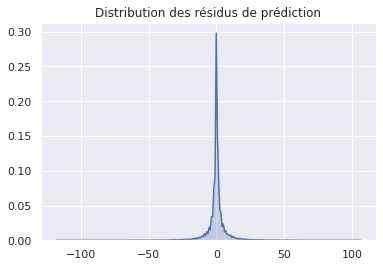

In [56]:
sns.kdeplot(y_pred - y_test, shade=True, gridsize=200)
plt.title('Distribution des résidus de prédiction');

Enfin on calcule la RMSE et la MAE. Ces indicateurs nous indiquent des erreurs directement en euros : 

In [45]:
print( "RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))
print("MAE = {}".format(mean_absolute_error(y_test, y_pred)))

RMSE = 8.719728102545242
MAE = 4.01643381678426


L'erreur RMSE est d'environ 9 €, la MAE d'environ 4 €. Ces valeurs semblent plutôt bonnes en première approximation.  
On pourrait aller plus loin en effectuant une cross-validation pour déterminer les meilleurs hyper-paramètres ou en testant d'autres algorithmes.